Ignore SSL error when pulling file from S3

In [408]:
# avoid SSL errors
import ssl

import numpy as np

ssl._create_default_https_context = ssl._create_unverified_context

Read dataset and show it

In [409]:
import pandas as pd

df = pd.read_csv("https://npg-ds.s3.amazonaws.com/titanic.csv")[:-1]
df.copy()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1.0,1.0,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1.0,1.0,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1.0,0.0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1.0,0.0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1.0,2.0,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1.0,0.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1.0,2.0,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3.0,0.0,"Zabour, Miss. Hileni",female,14.5000,1.0,0.0,2665,14.4542,NaN,C,NaN,328.0,NaN
1305,3.0,0.0,"Zabour, Miss. Thamine",female,NaN,1.0,0.0,2665,14.4542,NaN,C,NaN,NaN,NaN
1306,3.0,0.0,"Zakarian, Mr. Mapriededer",male,26.5000,0.0,0.0,2656,7.2250,NaN,C,NaN,304.0,NaN
1307,3.0,0.0,"Zakarian, Mr. Ortin",male,27.0000,0.0,0.0,2670,7.2250,NaN,C,NaN,NaN,NaN


The dataset has `1308` rows and the following columns:

* pclass: In which class  (1 = 1st; 2 = 2nd; 3 = 3rd)
* survived: Whether the passenger survived (0 = No; 1 = Yes)
* name: Name of the passenger
* sex: Sex
* age: Age in years
* sibsp: Number of Siblings/Spouses Aboard
* parch: Number of Parents/Children Aboard
* ticket: Ticket number
* fare: Passenger fare
* cabin: Cabin number
* embarked: Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)
* boat: Which boat the passenger got into
* body: Passenger was assigned a corpse number (died)
* home.dest: Home/Destination

Let's now start checking for some initial statistics about our dataset. For instance we could check for null values per column:

In [410]:
df.isnull().sum()

pclass          0
survived        0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
dtype: int64

We can see that `cabin` is missing a lot of values 1014 out of 1308. This means we can't use this column. If we were to fill the missing values with something calculated we would bias the data too much. Also we have other good options representing the same concept (`fare`, `pclass`).

We can also see that we are missing a lot of values for `boat`, that's okay because the missing values means that they didn't make it to the boat. We can replace the missing values with a zero to represent the ones that didn't make it to the boat. Same case for `body`.

Another conclusion we can take is that we are missing quite a few values for age, 263/1308. We will work around this by finding a way to replace the missing values with a value that make sense.

We are also missing quite a few `home.dest` values, but we don't really have use for those.

All in all, let's do the following:

* Remove `cabin`
* Remove `home.dest`
* Replace `null` values in `boat` for a 0, other values for a 1
* Replace `null` values in `body` for a 0, other values for a 1
* Replace missing age values for the mean (later we will try to create a model for predicting the age)

In [411]:
from typing import Any

# remove columns
df = df.drop("home.dest", axis=1)
df = df.drop("cabin", axis=1)

def convert_to_binomial(value: Any) -> int:
    if str(value) == str(np.nan):
        return 0
    return 1

# convert to binomial
df["boat"] = df.boat.apply(convert_to_binomial)
df["body"] = df.body.apply(convert_to_binomial)

# replace with mean
df["age"] = df["age"].fillna(df["age"].mean())
df.copy()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,embarked,boat,body
0,1.0,1.0,"Allen, Miss. Elisabeth Walton",female,29.000000,0.0,0.0,24160,211.3375,S,1,0
1,1.0,1.0,"Allison, Master. Hudson Trevor",male,0.916700,1.0,2.0,113781,151.5500,S,1,0
2,1.0,0.0,"Allison, Miss. Helen Loraine",female,2.000000,1.0,2.0,113781,151.5500,S,0,0
3,1.0,0.0,"Allison, Mr. Hudson Joshua Creighton",male,30.000000,1.0,2.0,113781,151.5500,S,0,1
4,1.0,0.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.000000,1.0,2.0,113781,151.5500,S,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3.0,0.0,"Zabour, Miss. Hileni",female,14.500000,1.0,0.0,2665,14.4542,C,0,1
1305,3.0,0.0,"Zabour, Miss. Thamine",female,29.881135,1.0,0.0,2665,14.4542,C,0,0
1306,3.0,0.0,"Zakarian, Mr. Mapriededer",male,26.500000,0.0,0.0,2656,7.2250,C,0,1
1307,3.0,0.0,"Zakarian, Mr. Ortin",male,27.000000,0.0,0.0,2670,7.2250,C,0,0


I'm going to do some initial cleaning in the data. Let get the prefix out of the name, it could probe useful later:

In [412]:
def get_prefix(name: str) -> str:
    # expected format: `Smith, Mr. James Clinch`
    forename, surname = name.split(",")
    prefix = surname.split(".")[0]
    return prefix.strip()

df["prefix"] = df["name"].map(get_prefix)
df.copy()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,embarked,boat,body,prefix
0,1.0,1.0,"Allen, Miss. Elisabeth Walton",female,29.000000,0.0,0.0,24160,211.3375,S,1,0,Miss
1,1.0,1.0,"Allison, Master. Hudson Trevor",male,0.916700,1.0,2.0,113781,151.5500,S,1,0,Master
2,1.0,0.0,"Allison, Miss. Helen Loraine",female,2.000000,1.0,2.0,113781,151.5500,S,0,0,Miss
3,1.0,0.0,"Allison, Mr. Hudson Joshua Creighton",male,30.000000,1.0,2.0,113781,151.5500,S,0,1,Mr
4,1.0,0.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.000000,1.0,2.0,113781,151.5500,S,0,0,Mrs
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3.0,0.0,"Zabour, Miss. Hileni",female,14.500000,1.0,0.0,2665,14.4542,C,0,1,Miss
1305,3.0,0.0,"Zabour, Miss. Thamine",female,29.881135,1.0,0.0,2665,14.4542,C,0,0,Miss
1306,3.0,0.0,"Zakarian, Mr. Mapriededer",male,26.500000,0.0,0.0,2656,7.2250,C,0,1,Mr
1307,3.0,0.0,"Zakarian, Mr. Ortin",male,27.000000,0.0,0.0,2670,7.2250,C,0,0,Mr


Let's now remove a few columns we won't use:

* Name: We don't need the name of the passenger for anything
* Embarked: Were the passenger embarked shouldn't make a difference, they were divided in classes anyway

In [413]:
df = df.drop("name", axis=1)
df = df.drop("embarked", axis=1)

# ignore prefix for now
df = df.drop("prefix", axis=1)

df.copy()

,pclass,survived,sex,age,sibsp,parch,ticket,fare,boat,body
0,1.0,1.0,female,29.000000,0.0,0.0,24160,211.3375,1,0
1,1.0,1.0,male,0.916700,1.0,2.0,113781,151.5500,1,0
2,1.0,0.0,female,2.000000,1.0,2.0,113781,151.5500,0,0
3,1.0,0.0,male,30.000000,1.0,2.0,113781,151.5500,0,1
4,1.0,0.0,female,25.000000,1.0,2.0,113781,151.5500,0,0
...,...,...,...,...,...,...,...,...,...,...
1304,3.0,0.0,female,14.500000,1.0,0.0,2665,14.4542,0,1
1305,3.0,0.0,female,29.881135,1.0,0.0,2665,14.4542,0,0
1306,3.0,0.0,male,26.500000,0.0,0.0,2656,7.2250,0,1
1307,3.0,0.0,male,27.000000,0.0,0.0,2670,7.2250,0,0


By looking at the columns we can see that we have some data we need to encode, `sex` and `prefix`. For encoding we will use one hot

In [414]:
from category_encoders import OneHotEncoder

encoder = OneHotEncoder()


ndf = encoder.fit_transform(df['sex'])
df["sex"] = ndf["sex_1"] # 0 is female, 1 is male
df.copy()

/Users/npg/Library/Caches/pypoetry/virtualenvs/mlucu-Vdmf4rJI-py3.8/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,pclass,survived,sex,age,sibsp,parch,ticket,fare,boat,body
0,1.0,1.0,1,29.000000,0.0,0.0,24160,211.3375,1,0
1,1.0,1.0,0,0.916700,1.0,2.0,113781,151.5500,1,0
2,1.0,0.0,1,2.000000,1.0,2.0,113781,151.5500,0,0
3,1.0,0.0,0,30.000000,1.0,2.0,113781,151.5500,0,1
4,1.0,0.0,1,25.000000,1.0,2.0,113781,151.5500,0,0
...,...,...,...,...,...,...,...,...,...,...
1304,3.0,0.0,1,14.500000,1.0,0.0,2665,14.4542,0,1
1305,3.0,0.0,1,29.881135,1.0,0.0,2665,14.4542,0,0
1306,3.0,0.0,0,26.500000,0.0,0.0,2656,7.2250,0,1
1307,3.0,0.0,0,27.000000,0.0,0.0,2670,7.2250,0,0


Let's try to run the correlation matrix and see how does the values we want to use correlate to each other:

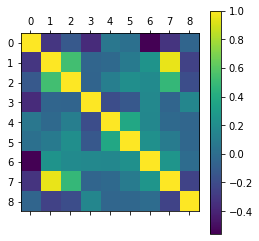

,pclass,survived,sex,age,sibsp,parch,fare,boat,body
pclass,1.000000,-0.312469,-0.124617,-0.366370,0.060832,0.018322,-0.558629,-0.323428,-0.049382
survived,-0.312469,1.000000,0.528693,-0.050199,-0.027825,0.082660,0.244265,0.948190,-0.250897
sex,-0.124617,0.528693,1.000000,-0.057398,0.109609,0.213125,0.185523,0.482086,-0.193214
age,-0.366370,-0.050199,-0.057398,1.000000,-0.190747,-0.130872,0.171892,-0.048172,0.157345
sibsp,0.060832,-0.027825,0.109609,-0.190747,1.000000,0.373587,0.160238,-0.026488,-0.046510
parch,0.018322,0.082660,0.213125,-0.130872,0.373587,1.000000,0.221539,0.089321,-0.038374
fare,-0.558629,0.244265,0.185523,0.171892,0.160238,0.221539,1.000000,0.252717,-0.007752
boat,-0.323428,0.948190,0.482086,-0.048172,-0.026488,0.089321,0.252717,1.000000,-0.245246
body,-0.049382,-0.250897,-0.193214,0.157345,-0.046510,-0.038374,-0.007752,-0.245246,1.000000


In [415]:
import matplotlib.pyplot as plt

# plot heatmap
plt.matshow(df.corr())
cb = plt.colorbar()
plt.show()

# show numerical values
df.corr()

After taking a look at the chart and the matrix, we can find a correlation between `fare` and `pclass` (around 0.5), between `body` and `survived` and . That tells us that we should remove one of those. The more representative one is `pclass` which tell us in which class the passenger was traveling, so let's keep that one and remove `fare`:

In [416]:
df = df.drop("fare", axis=1)
df.copy()

,pclass,survived,sex,age,sibsp,parch,ticket,boat,body
0,1.0,1.0,1,29.000000,0.0,0.0,24160,1,0
1,1.0,1.0,0,0.916700,1.0,2.0,113781,1,0
2,1.0,0.0,1,2.000000,1.0,2.0,113781,0,0
3,1.0,0.0,0,30.000000,1.0,2.0,113781,0,1
4,1.0,0.0,1,25.000000,1.0,2.0,113781,0,0
...,...,...,...,...,...,...,...,...,...
1304,3.0,0.0,1,14.500000,1.0,0.0,2665,0,1
1305,3.0,0.0,1,29.881135,1.0,0.0,2665,0,0
1306,3.0,0.0,0,26.500000,0.0,0.0,2656,0,1
1307,3.0,0.0,0,27.000000,0.0,0.0,2670,0,0


We want to predict the `survived` feature, so we can tell that if there is a `body` value then the person did not survived. This is a strict correlation with the resulting value so we don't want to include that. Let's proceed to remove it:

In [417]:
df = df.drop("body", axis=1)
df.copy()

,pclass,survived,sex,age,sibsp,parch,ticket,boat
0,1.0,1.0,1,29.000000,0.0,0.0,24160,1
1,1.0,1.0,0,0.916700,1.0,2.0,113781,1
2,1.0,0.0,1,2.000000,1.0,2.0,113781,0
3,1.0,0.0,0,30.000000,1.0,2.0,113781,0
4,1.0,0.0,1,25.000000,1.0,2.0,113781,0
...,...,...,...,...,...,...,...,...
1304,3.0,0.0,1,14.500000,1.0,0.0,2665,0
1305,3.0,0.0,1,29.881135,1.0,0.0,2665,0
1306,3.0,0.0,0,26.500000,0.0,0.0,2656,0
1307,3.0,0.0,0,27.000000,0.0,0.0,2670,0
